In [234]:
from src.features.gcca import gcca

import h5py
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from pathlib import Path
import os
import re
import pandas as pd

from tqdm import tqdm
from graspy.embed import select_dimension

np.set_printoptions(precision=3)

from graspy.plot import pairplot

In [247]:
def _preprocess(x):
    # Mean along rows using sample mean and sample std
    x2 = stats.zscore(x,axis=1,ddof=1) 
    # Mean along columns
    mu = np.mean(x2,axis=0)
    x2 -= mu
    return(x2)

## Group + Individual Simulation

In [101]:
ncol = 10
nrow = 1000
frac = 0.5

# Indivudal components
Ix = matlib.repmat(np.random.normal(2,1,size=(1,ncol)),nrow,1)
Iy = matlib.repmat(np.random.normal(2,1,size=(1,ncol)),nrow,1)

# Joint component
J = np.vstack((matlib.repmat(np.random.normal(1,1,size=(1,ncol)),int(nrow * frac),1),
               matlib.repmat(np.zeros((1,ncol)),int(nrow - nrow * frac),1)))

# Add
X = Ix + J + np.random.normal(0,1,size=Ix.shape)
Y = Iy + J + np.random.normal(0,1,size=Iy.shape)

In [137]:
projX,ranks,As = gcca(data=(X,Y), rank_tolerance=25, tall=False, return_meta=True)
print(ranks)

100%|██████████| 2/2 [00:00<00:00, 320.04it/s]


In [139]:
Jhats = [Xhat @ np.linalg.pinv(A) for Xhat,A in zip(projX,As)]

Jhat = np.mean(Jhats,axis=0)
Ixhat = X - Jhat
Iyhat = Y - Jhat

In [142]:
sse_J = (J-Jhat).flatten(); sse_J /= len(sse_J)
sse_Ix = (Ix-Ixhat).flatten(); sse_Ix /= len(sse_Ix)
sse_Iy = (Iy-Iyhat).flatten(); sse_Iy /= len(sse_Iy)

## Vary rank tolerance

In [191]:
n = 100
m = 10
d = 1
n_sample = 2
latent = np.random.normal(2,1,size=(n,d))
projs = [np.random.choice([-1,1], size=(d,m)) for _ in range(n_sample)]
data = [latent @ proj + np.random.normal(0,1,size=(n,m)) for proj in projs]

In [192]:
diffs = []
rlist = []
for rt in np.arange(1,1000,100):
    projX,ranks,As = gcca(data=data, rank_tolerance=0.01, tall=False, return_meta=True)
    rlist.append(min(ranks))
    diffs.append(latent - np.mean(projX,axis=0))

100%|██████████| 2/2 [00:00<00:00, 433.47it/s]


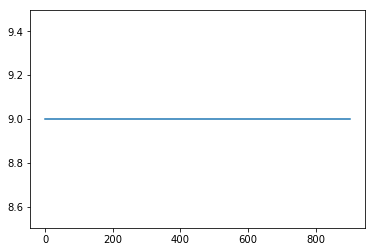

In [193]:
plt.plot(np.arange(1,1000,100),rlist)

## Zhu Godsie

[0.728 0.874 0.967 1.   ]


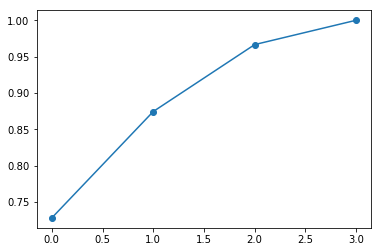

In [258]:
_,s,_ = np.linalg.svd(X)
s /= sum(s)
s = np.cumsum(s)
print(s)
plt.plot(range(len(s)), s,'-o')

## Correlation and separability

In [259]:
X = np.hstack((np.arange(1,11).reshape(10,-1), np.random.normal(0,1,size=(10,3))))
Y = np.hstack((10*np.arange(1,11).reshape(10,-1), np.random.normal(0,1,size=(10,3))))
data = np.vstack((X,Y))
labels = ['X'] * 10 + ['Y'] * 10

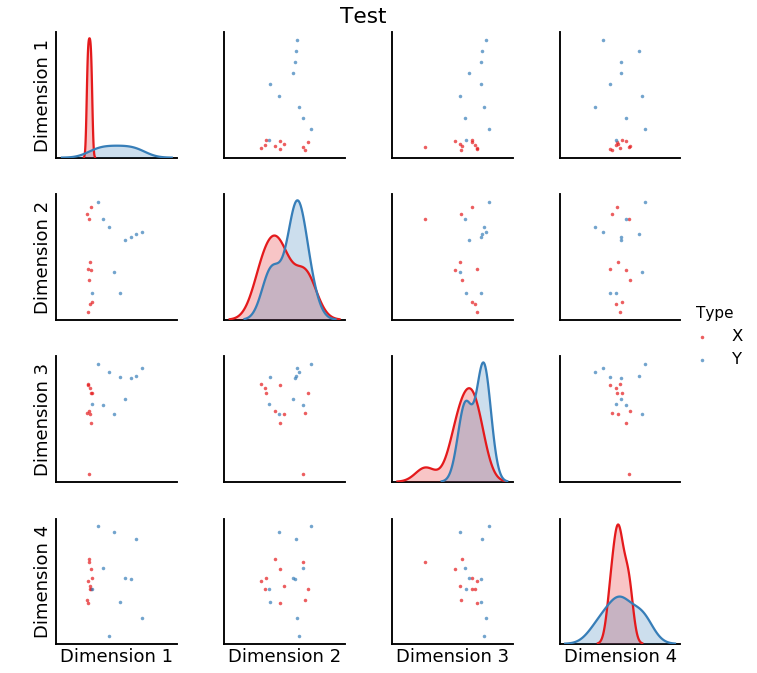

In [260]:
plot = pairplot(data, labels,title='Test')

In [261]:
projX,ranks,As = gcca(data=(X,Y), rank_tolerance=0.01, tall=False, return_meta=True)

100%|██████████| 2/2 [00:00<00:00, 1056.50it/s]


In [262]:
projX

[array([[ 0.503, -0.653],
        [-1.257, -1.339],
        [-1.555,  1.682],
        [ 1.912,  0.976],
        [ 0.354,  0.836],
        [-0.681,  0.235],
        [ 0.35 , -0.579],
        [ 0.331, -1.362],
        [ 0.39 , -0.025],
        [-0.347,  0.23 ]]), array([[ 0.362, -1.001],
        [-1.42 ,  0.104],
        [-1.374,  1.66 ],
        [ 1.492,  1.736],
        [-1.022, -1.044],
        [ 1.053, -0.837],
        [-0.082,  0.075],
        [ 0.303, -0.17 ],
        [-0.009, -0.619],
        [ 0.697,  0.096]])]

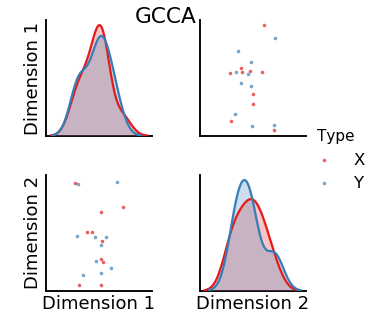

In [265]:
plot = pairplot(np.vstack(projX), labels,title='GCCA')